In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import shap


In [3]:
!ls ../data/

2007-2016-Homelessnewss-USA.csv
2007-2016-Homelessnewss-USA.csv (1).zip
City_time_series.csv
City_time_series.csv.zip
README.md
State_time_series.csv
countypres_2000-2020.csv
homeless_count_Econ_Politics_by_state.csv
homeless_count_with_housing_price_by_state.csv
homeless_people_by_state.csv
homeless_people_distribution_overtime.png
homeless_vs_housing_correlation_heatmap.png
housing_sale_price_overtime.png
profile_by_county_1969_2019.csv
realtor-data.csv
scaled_X_test.csv
scaled_X_train.csv
scaled_y_test.csv
scaled_y_train.csv
usa-real-estate-dataset.zip


In [4]:
X_train = pd.read_csv("../data/scaled_X_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

In [5]:
# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

## RandomForestRegressor

In [6]:
# train a randomForestRegressor model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# prediction
y_train_predict = rfr.predict(X_train)
y_test_predict = rfr.predict(X_test)


#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)
randomForestRegressor_train_r2 = rfr.score(X_train, y_train)
randomForestRegressor_test_r2 = rfr.score(X_test, y_test)

print("Random Forest Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_r2:.4f}")

Random Forest Regressor results:

	Train MSE	0.0328
	Test MSE	0.3457

	Train R-squared	0.9695
	Test R-squared	0.5038


The train and test MSE is small, but the R-squared values differ a lot. Therefore, it seems like the model overfitted. Perform a GridSearchCV

In [13]:
gsc_rfr = GridSearchCV(
        estimator=RandomForestRegressor(random_state=300),
        param_grid={
            "max_depth": range(1,7),
            'n_estimators': (1,10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result_rfr = gsc_rfr.fit(X_train, y_train.values.ravel())
best_params_rfr = grid_result_rfr.best_params_

grid_rfr = RandomForestRegressor(max_depth = best_params_rfr["max_depth"], n_estimators=best_params_rfr["n_estimators"], bootstrap=True, random_state=300, verbose=False)

grid_rfr.fit(X_train, y_train)

# prediction
y_train_GridCV_predict = grid_rfr.predict(X_train)
y_test_GridCV_predict = grid_rfr.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)
randomForestRegressor_train_GridCV_r2 = grid_rfr.score(X_train, y_train)
randomForestRegressor_test_GridCV_r2 = grid_rfr.score(X_test, y_test)

print("Random Forest Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_GridCV_r2:.4f}")

Random Forest Regressor Gridsearch results:

	Train MSE	0.0348
	Test MSE	0.1661

	Train R-squared	0.9676
	Test R-squared	0.7616


# BaggingRegressor

In [8]:
bagging_ensemble = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators=1, 
                                    max_features=1.0, bootstrap_features=False, random_state=300).fit(X_train, y_train)


# prediction
y_train_bagging_predict = bagging_ensemble.predict(X_train)
y_test_bagging_predict = bagging_ensemble.predict(X_test)


#Compute the MSE of the model
bagging_train_mse = mean_squared_error(y_train,y_train_bagging_predict)
bagging_test_mse = mean_squared_error(y_test,y_test_bagging_predict)
bagging_ensemble_train_GridCV_r2 = bagging_ensemble.score(X_train, y_train)
bagging_ensemble_test_GridCV_r2 = bagging_ensemble.score(X_test, y_test)

print("Bagging Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        bagging_train_mse,
        bagging_test_mse,
    )
)

print(f"\tTrain R-squared\t{bagging_ensemble_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{bagging_ensemble_test_GridCV_r2:.4f}")

Bagging Regressor results:

	Train MSE	0.0219
	Test MSE	0.1940

	Train R-squared	0.9796
	Test R-squared	0.7215


Perform a GridSearchCV to better turn the model

In [15]:
gsc_br = GridSearchCV(
        estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=300), random_state=300),
        param_grid={
            "base_estimator__max_depth": range(1,20),
            'n_estimators': (1,10, 50, 100, 1000)
        },
        cv=10, scoring='neg_mean_squared_error', n_jobs=-1)


grid_result_br = gsc_br.fit(X_train, y_train.values.ravel())
best_params_br = grid_result_br.best_params_

grid_bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=best_params_br["base_estimator__max_depth"], random_state=300),
                                n_estimators=best_params_br["n_estimators"], random_state=300)

grid_bagging.fit(X_train, y_train.values.ravel())

# prediction
y_train_GridCV_predict = grid_bagging.predict(X_train)
y_test_GridCV_predict = grid_bagging.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)

baggingRegressor_train_GridCV_r2 = grid_bagging.score(X_train, y_train)
baggingRegressor_test_GridCV_r2 = grid_bagging.score(X_test, y_test)

print("Bagging Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{baggingRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{baggingRegressor_test_GridCV_r2:.4f}")

Bagging Regressor Gridsearch results:

	Train MSE	0.0181
	Test MSE	0.1311

	Train R-squared	0.9831
	Test R-squared	0.8119


## Feature Importance

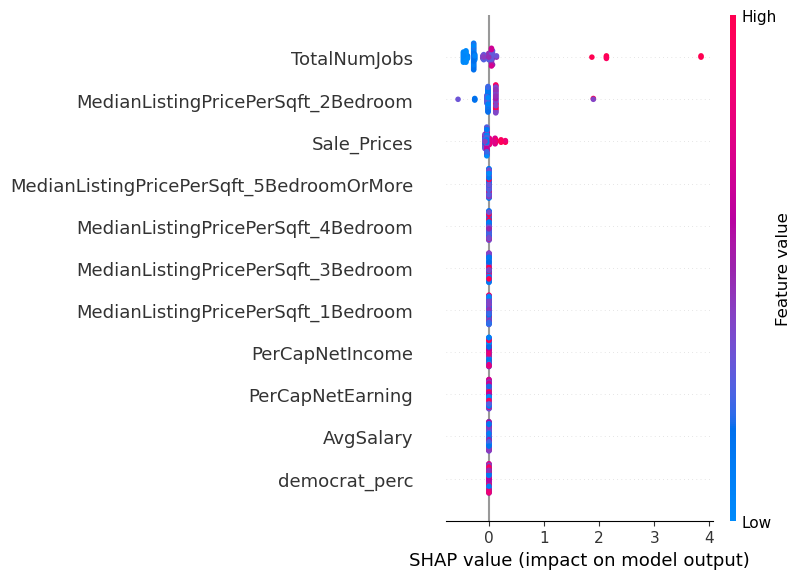

In [49]:
explainer_baggingRegressor = shap.TreeExplainer(grid_rfr)
shap_values = explainer_baggingRegressor.shap_values(X_train)

shap.summary_plot(shap_values, X_train, title="RandomForestRegressor Feature Importance (Train)")

Since the BaggingRegressor used with many base estimators, and shap library does not support the baggingRegressor, so we need to extract the feature_importances_ ourselves. 

In [26]:
X_train.columns

Index(['democrat_perc', 'AvgSalary', 'PerCapNetEarning', 'PerCapNetIncome',
       'TotalNumJobs', 'Sale_Prices', 'MedianListingPricePerSqft_1Bedroom',
       'MedianListingPricePerSqft_2Bedroom',
       'MedianListingPricePerSqft_3Bedroom',
       'MedianListingPricePerSqft_4Bedroom',
       'MedianListingPricePerSqft_5BedroomOrMore'],
      dtype='object')

Text(0.5, 1.0, 'BaggingRegressor feature importance')

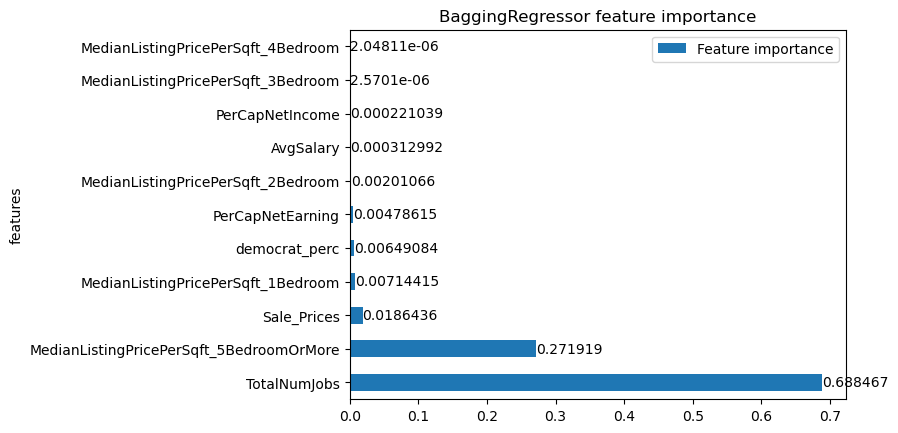

In [46]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in grid_bagging.estimators_
], axis=0)
feature_importances

feature_importances_plot = list(zip(list(X_train.columns), feature_importances))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("BaggingRegressor feature importance")